In [8]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from IPython.display import display

# AYARLAR

# Modellerin bulunduğu ortak klasörün yolu
MODEL_FOLDER = '/content/drive/MyDrive/diabet_erken_teshis/kaydedilmismodeller_group4/'

# Test Verisi Yolları
X_TEST_PATH = '/content/drive/MyDrive/diabet_erken_teshis/X_test.csv'
Y_TEST_PATH = '/content/drive/MyDrive/diabet_erken_teshis/y_test.csv'

# Özellik uyumsuzluğu olan modeller için manuel özellik sayıları
BEKLENEN_OZELLIK_SAYILARI = {
    'lda_model.pkl': 5,
    'perceptron_new_params_l2_penalty.joblib': 50,
}

# 1. Veri ve Metrik Hazırlığı

# Test verilerini yükle
try:
    X_test = pd.read_csv(X_TEST_PATH)
    y_test = pd.read_csv(Y_TEST_PATH).values.ravel()
    # Test verisinin boyutu
    original_feature_count = X_test.shape[1]
    print(f"Test verisi başarıyla yüklendi. Özellik Sayısı: {original_feature_count}")
except FileNotFoundError:
    print("HATA: Test verileri bulunamadı. Lütfen dosya yollarını kontrol edin.")
    exit()

# Sonuçları tutacak boş DataFrame
final_comparison_df = pd.DataFrame(columns=['Uye', 'Model_Turu', 'Accuracy', 'Recall', 'F1_Score', 'AUC_Score'])
roc_curves = {} # ROC eğrisi verilerini tutmak için sözlük

print(f"\n--- {MODEL_FOLDER} Klasöründeki Modeller Yükleniyor ve Değerlendiriliyor ---")

# 2. Modelleri Yükleme, Uyumlandırma ve Değerlendirme Döngüsü

for filename in os.listdir(MODEL_FOLDER):
    if filename.endswith(('.pkl', '.joblib')):

        full_path = os.path.join(MODEL_FOLDER, filename)

        # Dosya adından Üye ve Model adını çıkar
        try:
            name_parts = filename.split('_')
            uye_adi = name_parts[0]
            model_turu = name_parts[1].split('.')[0] # .pkl uzantısını kaldır
        except IndexError:
            # İsimlendirme standardına uymayan dosyaları atla
            print(f"Uyarı: {filename} dosyası 'Uye_Model.pkl' formatında değil, atlanıyor.")
            continue

        try:
            # Modeli yükle
            model = joblib.load(full_path)

            # ÖZELLİK SAYISI UYUMLANDIRMA
            beklenen_ozellik_sayisi = BEKLENEN_OZELLIK_SAYILARI.get(filename, original_feature_count)

            if beklenen_ozellik_sayisi != original_feature_count:
                # Özellik azaltma yapılmış model. İlk N sütunu alıyoruz.
                X_test_kullan = X_test.iloc[:, :beklenen_ozellik_sayisi]
                print(f"Uyarı: {filename} için X_test, {beklenen_ozellik_sayisi} özelliğe filtrelendi.")
            else:
                # Model 132 özellik bekliyor
                X_test_kullan = X_test

            # Tahminleri yap
            y_pred = model.predict(X_test_kullan)

            # AUC ve ROC İçin predict_proba Kontrolü
            auc = np.nan
            y_probs = None

            # Modelin predict_proba metoduna sahip olup olmadığını kontrol et
            if hasattr(model, 'predict_proba'):
                y_probs = model.predict_proba(X_test_kullan)[:, 1]
                auc = roc_auc_score(y_test, y_probs)
                # ROC verilerini kaydet
                fpr, tpr, _ = roc_curve(y_test, y_probs)
                roc_curves[f"{uye_adi}_{model_turu}"] = (fpr, tpr, auc)
            else:
                print(f"Uyarı: {filename} ({model_turu}) için AUC/ROC (predict_proba) hesaplanamadı.")

            # Metrikleri hesapla
            acc = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            # Sonucu DataFrame'e ekle
            new_row = {
                'Uye': uye_adi,
                'Model_Turu': model_turu,
                'Accuracy': round(acc, 4),
                'Recall': round(recall, 4),
                'F1_Score': round(f1, 4),
                'AUC_Score': round(auc, 4)
            }
            final_comparison_df.loc[len(final_comparison_df)] = new_row
            print(f" {uye_adi} ({model_turu}): Başarılı.")

        except Exception as e:
            # Genel hata yakalama, burada kalan özellik uyumsuzlukları da yakalanır
            print(f" HATA: {filename} yüklenirken veya değerlendirilirken sorun oluştu: {e}")

# 3. Sonuçların Gösterimi ve Rapor Çıktısı

print("\n" + "="*70)
print(" RAPOR İÇİN NİHAİ KARŞILAŞTIRMA TABLOSU ")
print("="*70)

# F1 Skoruna göre sırala
df_final = final_comparison_df.sort_values(by='F1_Score', ascending=False).reset_index(drop=True)
display(df_final)

# Model Şampiyonu
if not df_final.empty:
    champion_model_info = df_final.iloc[0]
    print(f"\n ŞAMPİYON MODEL (F1 Skoru En Yüksek): {champion_model_info['Uye']} - {champion_model_info['Model_Turu']}")

# Grafikler
plt.style.use('ggplot')


Test verisi başarıyla yüklendi. Özellik Sayısı: 132

--- /content/drive/MyDrive/diabet_erken_teshis/saved_models_group4/ Klasöründeki Modeller Yükleniyor ve Değerlendiriliyor ---
 sampiyon (model): Başarılı.
 best (model): Başarılı.
Uyarı: lda_model.pkl için X_test, 5 özelliğe filtrelendi.
 lda (model): Başarılı.
Uyarı: perceptron_new_params_l2_penalty.joblib için X_test, 50 özelliğe filtrelendi.
Uyarı: perceptron_new_params_l2_penalty.joblib (new) için AUC/ROC (predict_proba) hesaplanamadı.
 perceptron (new): Başarılı.

 RAPOR İÇİN NİHAİ KARŞILAŞTIRMA TABLOSU 


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Perceptron was fitted without feature names
  warnings.warn(


,Uye,Model_Turu,Accuracy,Recall,F1_Score,AUC_Score
0,best,model,0.6675,0.5711,0.2771,0.6707
1,sampiyon,model,0.6180,0.6292,0.2688,0.6616
2,lda,model,0.1116,1.0000,0.2008,0.5232
3,perceptron,new,0.8873,0.0238,0.0450,NaN



 ŞAMPİYON MODEL (F1 Skoru En Yüksek): best - model


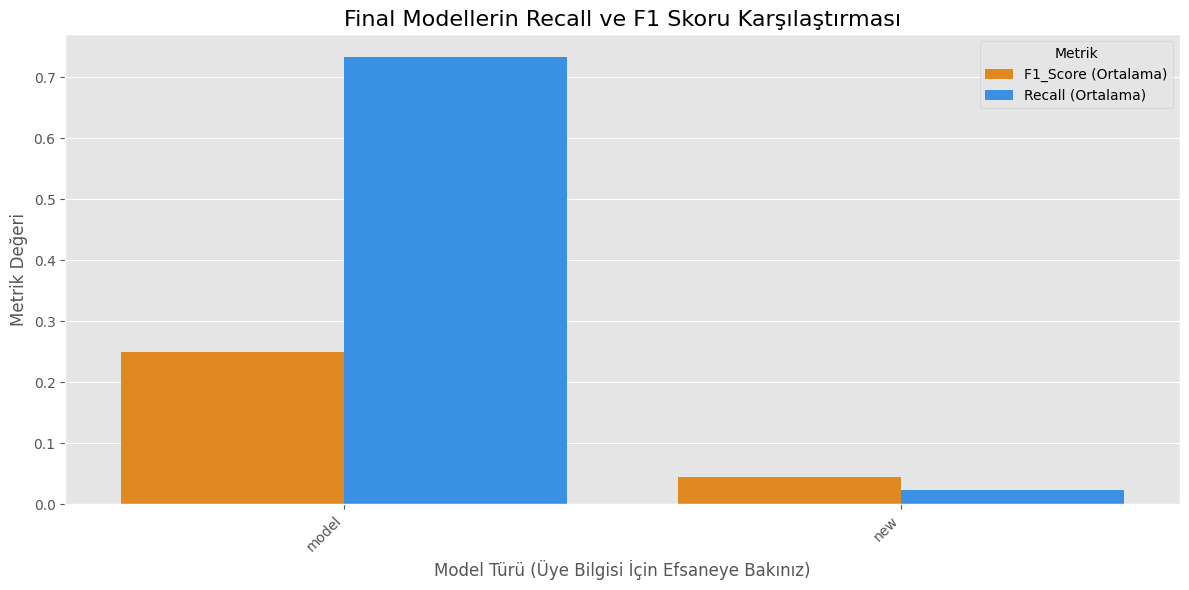

In [9]:
# Görsel 1: F1 ve Recall Karşılaştırması
plt.figure(figsize=(12, 6))
# DataFrame'i görselleştirme için hazırla
df_plot = df_final.melt(id_vars=['Uye', 'Model_Turu'], value_vars=['F1_Score', 'Recall'],
                        var_name='Metrik', value_name='Değer')

sns.barplot(data=df_plot,
            x='Model_Turu',
            y='Değer',
            hue='Metrik',
            palette={'F1_Score': 'darkorange', 'Recall': 'dodgerblue'},
            errorbar=None) # errorbar=None ekleyerek hata çubuklarını kaldırıyoruz (tek bir değer olduğu için)

plt.title('Final Modellerin Recall ve F1 Skoru Karşılaştırması', fontsize=16)
plt.ylabel('Metrik Değeri')
plt.xlabel('Model Türü (Üye Bilgisi İçin Efsaneye Bakınız)')
plt.xticks(rotation=45, ha='right')
# Model adlarına üye adını da ekleyelim
handles, labels = plt.gca().get_legend_handles_labels()
new_labels = [f"{m} (Ortalama)" if m in ['F1_Score', 'Recall'] else m for m in labels]
plt.legend(handles, new_labels, title='Metrik', loc='upper right')
plt.tight_layout()
plt.show()


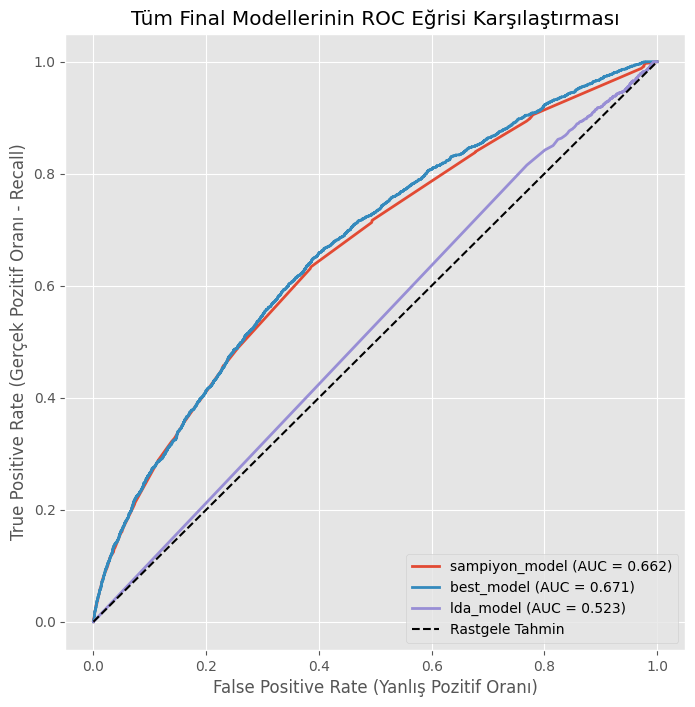

In [10]:
# Görsel 2: Tüm Modeller İçin ROC Eğrisi
if roc_curves:
    plt.figure(figsize=(8, 8))
    for name, (fpr, tpr, auc) in roc_curves.items():
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Tahmin')
    plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)')
    plt.ylabel('True Positive Rate (Gerçek Pozitif Oranı - Recall)')
    plt.title('Tüm Final Modellerinin ROC Eğrisi Karşılaştırması')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True)
    plt.show()
else:
    print("\nAUC ve ROC Eğrisi, tüm modellerde 'predict_proba' metodu bulunmadığı için çizilemedi.")